# 0. Setup

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-9d5e4f83-3f58-2974-ee70-21df15226f84)


In [26]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix
from misc.helpers import find_pth_files, resize_and_normalize_attention_maps, calculate_true_distributions
from scipy.stats import entropy
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from model.vit_for_small_dataset_custom import ViT
from utils.imageset_handler import ImageQualityDataset


# 1. Build Model

### 1.1 Define Variables

In [30]:
image_size=256
patch_size=16
num_classes=5  # Number of classes for image quality levels
dim=1024
depth=6
heads=16
mlp_dim=2048
emb_dropout=0.1

### 1.2 Compile

In [47]:
model = ViT(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=dim,
    depth=depth,
    heads=heads,
    mlp_dim=mlp_dim,
    emb_dropout=emb_dropout
)
print(model)

ViT(
  (to_patch_embedding): SPT(
    (to_patch_tokens): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
      (1): LayerNorm((3840,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=3840, out_features=1024, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fn): LSA(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.0, inplace=False)
            (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=1024, out_features=1024, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (

# 2 Load Dataset

In [57]:
weights_dir = 'results/weights/AIO1_normalverteilung'

csv_file = 'assets/Test/Obs1.csv'
dataset_root =  'assets/Test/DSX'
batch_size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 2.1 Add Augmentation (Transformation)

In [58]:
# Define the normalization parameters (mean and std)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define the transformation including normalization
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


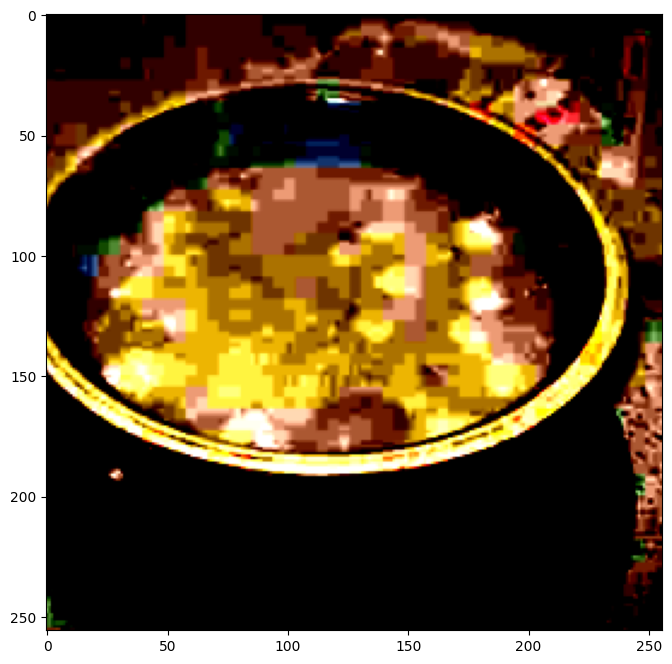

Transformed image saved to /home/maxgan/WORKSPACE/UNI/BA/präsi bilder/1675ILSVRC2013_train_00027470.JPEG_I1_Q7_transformed.jpg


In [25]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch

# Load the image
image_path = "assets/Test/DSX/1675ILSVRC2013_train_00027470.JPEG_I1_Q7.jpeg"
image = Image.open(image_path)

# Apply the transformation
transformed_image = transform(image)

# Save the transformed image
output_path = "/home/maxgan/WORKSPACE/UNI/BA/präsi bilder/1675ILSVRC2013_train_00027470.JPEG_I1_Q7_transformed.jpg"
pil_image = transforms.ToPILImage()(transformed_image)

# Convert the PyTorch tensor to a NumPy array and permute the channels
transformed_image = transformed_image.permute(1, 2, 0).numpy()

# Display the image using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(transformed_image)
plt.show()

# Save the PIL image
pil_image.save(output_path)

print(f"Transformed image saved to {output_path}")


### 2.2 Loading

In [59]:
# Initialize your dataset loader and test dataset
test_dataset = ImageQualityDataset(csv_file,dataset_root, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# model.to(device)

Number of images in the dataset: 300


# 3. Evaluate

### 3.1 Evaluating best weights

In [65]:
# Varianz
sigma = 0.7

# List of different weight files
weight_files = find_pth_files(weights_dir)

results = []
example_pred_results = []

for weight_file in weight_files:
    print(f'Weights-file: {os.path.basename(weight_file)} will be evaluated')
    # Load the model with different weights
    model.load_state_dict(torch.load(weight_file))
    model.eval()

    # init result lists
    true_labels = []
    test_preds = []
    entropies = []
    true_entropies =[]
    weighted_sums = []
    kl_divs = []
    with torch.no_grad():

        for i, (images, labels) in enumerate(test_loader, 0):
            # images = images.to(device)
            # labels = labels.to(device)
            print(f"Example Prediction of Batch: {i}")
            outputs, _ = model(images)
            true_labels.extend(labels)

            # Convert logits to probabilities
            probabilities = nn.functional.softmax(outputs, dim=1)
            
            # Calculate the true distribution based on 'sigma'
            true_distributions = calculate_true_distributions(labels,sigma,num_classes,device='cpu')

            # Get predicition by the maximum probability
            _, preds = torch.max(outputs, dim=1)
            test_preds.extend(preds.cpu().numpy())
            
            formatted_probabilities = ["{:.4f}".format(prob) for prob in probabilities[0]]
            # print(f"Predicted Probabilities:{formatted_probabilities}")
            # print(f'Predicted Label: {preds[0]}')


            # Calculate Entropy
            entropy_values = entropy(probabilities.numpy(),base=np.exp(1), axis=1)
            true_entropy_values = entropy(true_distributions.numpy(),base=np.exp(1), axis=1)
            # Format entropies in a readble way
            entropies.extend(entropy_values)
            true_entropies.extend(entropy_values)
            # print(f'Mean Entropie of batch: {np.mean(entropy_values)}')

            # Calculate KL Divergence
            # kl_div = torch.nn.functional.kl_div(torch.log(probabilities), true_distributions, reduction='none')
            # print(f'KL-Divergence none: {kl_div[0]}')
            # kl_div = torch.sum(kl_div, dim=1).numpy()
            # print(f'KL-Divergence sum: {kl_div[0]}')
            # kl_div = torch.nn.functional.kl_div(torch.log(probabilities), true_distributions, reduction='mean')
            # print(f'KL-Divergence mean: {kl_div}')

            kl_div = torch.nn.functional.kl_div(torch.log(probabilities), true_distributions, reduction='batchmean')
            # print(f'KL-Divergence batchmean: {kl_div}')
            kl_divs.append(kl_div.item())
            
            # Define weighting factors
            weighting_factors = [0,1,2,3,4]
            # Calculate the weighted sum of probabilities
            weighted_sum = torch.sum(probabilities * torch.tensor(weighting_factors), dim=1).cpu().numpy()
            # Format weighted sum in a readble way
            weighted_sums.extend(weighted_sum)
            # Example printout for the first batch
            if i == 0 or i == 1:
                example_pred_result = {
                    "Weights File": os.path.basename(weight_file),
                    "True Label": labels.cpu().numpy()[i],
                    "Predicted Label": preds.cpu().numpy()[i],
                    "Weighted Sum of Probability": weighted_sum[i],
                    "True Probability Distribution": true_distributions[i].cpu().numpy().tolist(),
                    "Predicted Probability Distribution": probabilities[i].cpu().numpy().tolist(),
                    "Entropy Value": entropy_values[i],
                    "True Entropy Value": true_entropy_values[i],
                    "KL Divergence (batch-mean)": kl_divs[i],
                }
                example_pred_results.append(example_pred_result)
            print(f'True-Label: {labels.cpu()[0]}')
            print(f'Predicted-Label: {preds.cpu().numpy()[0]}')
            print(f'Weighted Sum of Probability: {round(weighted_sum[0],4)}')  # Gewichtete Summe der Wahrscheinlichkeiten
            print(f'Predicted Probality Distribution: {[round(prob,4) for prob in probabilities[0].numpy()]}')
            print(f'True Probality Distribution: {true_distributions.cpu().numpy()[0]}')
            print(f'Entropy Value: {round(entropy_values[0],4)}') # High Value: spreading; Low Value: concentrated
            print(f'True Entropy Value: {round(true_entropy_values[0],4)}') # High Value: spreading; Low Value: concentrated
            print(f'KL Divergence (batch-mean): {round(kl_div.item(),4)}\n')



    # Calculate the MSE of weighted sum and ground truth
    mse_weighted = mean_squared_error(true_labels, weighted_sums)

    # Calculate the MSE of most likely class and ground truth
    mse = mean_squared_error(true_labels, test_preds)
    
    # Calculate the Mean Entropy
    mean_entropy = np.mean(entropies)
    
    # Calculate the Mean KL Divergence
    mean_kl_div = np.mean(kl_divs)

    # Calculate Accuracy
    accuracy = accuracy_score(true_labels, test_preds)

    # Generate classification report
    class_report = classification_report(true_labels, test_preds)

    # Generate confusion matrix
    confusion = confusion_matrix(true_labels, test_preds)
    print('#'*50)
    print('model summary:')
    # print(f'Weight: {os.path.basename(weight_file)}, Accuracy: {accuracy}, Mean Entropy: {mean_entropy}, Mean KL Div: {mean_kl_div:.4f}, weighted mean mse: {mse_weighted},\nClassification Report:\n{class_report}')
    # Save confusion matrix as a figure
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.savefig(weight_file.replace(".pth", "_confusion.png"))
    plt.close()
    result = {
        "Weights File": os.path.basename(weight_file),
        "Accuracy": accuracy,
        "MSE": mse,
        "MSE weighted": mse_weighted,
        "Mean Entropy": mean_entropy,
        "Mean KL Divergence": mean_kl_div, 
        "Classification Report": class_report
    }
    # Store the results
    results.append(result)
    # Print summary
    for key, value in result.items():
        print(f"{key}: {value}")
    print('#'*50)

# Create a DataFrame and save to CSV
results_df = pd.DataFrame(results)
results_path = os.path.join(weights_dir, "model_comparison_results.csv")
results_df.to_csv(results_path, index=False)

# Save example printouts to a CSV file for this model
example_printouts_df = pd.DataFrame(example_pred_results)
example_printout_file = os.path.join(weights_dir, "model_comparison_results_examples.csv")
example_printouts_df.to_csv(example_printout_file, index=False)

Weights-file: vit_model_20231030_132629_epoch_13of100_valLoss_1.256_valAcc_0.617_batchsize_128_lr_0.0_DS1.pth will be evaluated
Example Prediction of Batch: 0
True-Label: 1
Predicted-Label: 0
Weighted Sum of Probability: 0.3361000120639801
Predicted Probality Distribution: [0.7078, 0.2521, 0.037, 0.0024, 0.0007]
True Probality Distribution: [2.0740682e-01 5.7541430e-01 2.0740682e-01 9.7129270e-03 5.9096561e-05]
Entropy Value: 0.7335000038146973
True Entropy Value: 1.0161000490188599
KL Divergence (batch-mean): 0.2464

Example Prediction of Batch: 1
True-Label: 2
Predicted-Label: 2
Weighted Sum of Probability: 2.2248001098632812
Predicted Probality Distribution: [0.0055, 0.0671, 0.6338, 0.2841, 0.0095]
True Probality Distribution: [0.00962006 0.2054237  0.5699125  0.2054237  0.00962006]
Entropy Value: 0.9006999731063843
True Entropy Value: 1.059999942779541
KL Divergence (batch-mean): 0.2856

Example Prediction of Batch: 2
True-Label: 2
Predicted-Label: 2
Weighted Sum of Probability: 1.

### 3.2 Plot Mean Attention

In [20]:
weight_file = 'results/weights/AIO5/vit_model_20231011_132645_epoch_26of100_valLoss_0.873_valAcc_0.622_batchsize_128_lr_0.0_Obs5.pth'

image_size=256
patch_size=16
num_classes=5  # Number of classes for image quality levels
dim=1024
depth=6
heads=16
mlp_dim=2048
emb_dropout=0.1

model = ViT(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=dim,
    depth=depth,
    heads=heads,
    mlp_dim=mlp_dim,
    emb_dropout=emb_dropout,
    # pool='mean'
)
print(model)

model.load_state_dict(torch.load(weight_file))
model.eval()

ViT(
  (to_patch_embedding): SPT(
    (to_patch_tokens): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
      (1): LayerNorm((3840,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=3840, out_features=1024, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fn): LSA(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.0, inplace=False)
            (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=1024, out_features=1024, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (

ViT(
  (to_patch_embedding): SPT(
    (to_patch_tokens): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
      (1): LayerNorm((3840,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=3840, out_features=1024, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fn): LSA(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.0, inplace=False)
            (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=1024, out_features=1024, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Out: torch.Size([1, 5])
Predicted Class: 1
Probabilities: ['0.0000', '1.0000', '0.0000', '0.0000', '0.0000']
Predicted Class (weighted): 1.0000
Attention - Shape: torch.Size([1, 6, 16, 257, 257])
Attention - Mean: torch.Size([6, 256, 256])
Image: torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


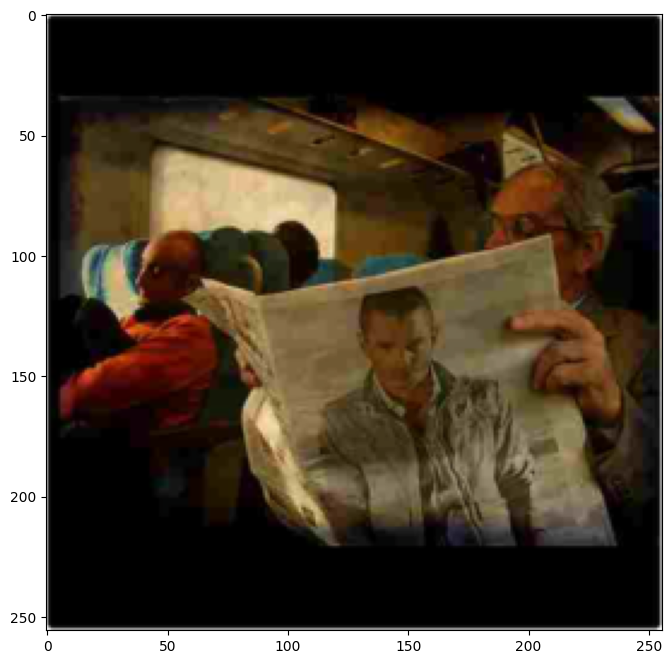

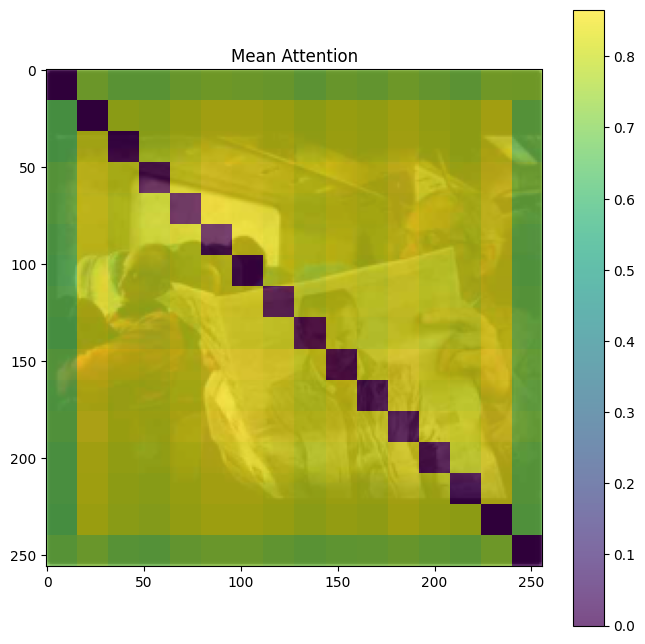

In [13]:
image_path = 'assets/Test/TestImg/171ILSVRC2013_train_00001022.JPEG_I2_Q14.jpeg'
# image_path = '/home/maxgan/Downloads/vit_model_20230909_021136_epoch_89of150_valLoss_0.134_valAcc_0.941_batchsize_128_lr_0.0_allDistorted_confusion.jpg'

image_org = Image.open(image_path)


image = transform(image_org)
with torch.no_grad():
    out, att = model(image.unsqueeze(0))
    print(f"Out: {out.shape}")
    _, preds = torch.max(out, 1)
    print(f"Predicted Class: {preds.cpu().numpy()[0]}")
    probabilities = nn.functional.softmax(out, dim=1)
    # Format probabilities in a readble way
    formatted_probs = [[f'{p:.4f}' for p in prob_list] for prob_list in probabilities.numpy()]
    print(f"Probabilities: {formatted_probs[0]}")    

    # Define weighting factors
    weighting_factors = [0,1,2,3,4]
    # Calculate the weighted sum of probabilities
    weighted_sum = torch.sum(probabilities * torch.tensor(weighting_factors), dim=1).cpu().numpy()
    # Format weighted sum in a readble way
    formatted_weighted_sum = [f'{sum:.4f}' for sum in weighted_sum]
    print(f"Predicted Class (weighted): {formatted_weighted_sum[0]}")

    # print(f"Attention - Shape: {att.shape}") # batch, layers (depth), heads, sequence length, sequence length
    print(f"Attention - Shape: {att.shape}") # batch, layers (depth), heads, sequence length, sequence length
    attn_patches = att[:, :, :,1:, 1:] # No Class-Token
    attn_patches = attn_patches.squeeze(0) # No Batch => layers (depth), heads, sequence length, sequence length
    att_mean = torch.mean(attn_patches, dim=1) # Mean of Heads

    att_mean_scores = att_mean.cpu().numpy()

    print(f"Attention - Mean: {att_mean.shape}") # layers (depth), sequence length, sequence length
    # Overlay attention maps on the image patches
    # Reverse the normalization
    image = image.permute(1, 2, 0)  # Convert to HxWxC format
    image = image * np.array(std) + np.array(mean)

    print(f"Image: {image.shape}")
    # Plot the original image with overlaid attention maps
    plt.figure(figsize=(8, 8))
    plt.imshow(image)  # Display the original image
    # Resize and normalize attention maps
    resized_and_normalized_attention_maps = resize_and_normalize_attention_maps(
        att_mean_scores, patch_size, image_size
    )
    
    resized_and_normalized_attention_maps = np.stack(resized_and_normalized_attention_maps, axis=0)
    resized_and_normalized_attention_map = np.mean(resized_and_normalized_attention_maps, axis=0)
    # Plot the original image with overlaid attention maps
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.imshow(resized_and_normalized_attention_map, alpha=0.7, cmap='viridis', interpolation='nearest')
    plt.title(f'Mean Attention')
    plt.colorbar()
    plt.show()


### Plot Attention Per Layer

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class: 0
Probabilities: [8.1961286e-01 1.6006511e-01 1.9546248e-02 6.8885484e-04 8.6934619e-05]
Attention - Shape: torch.Size([1, 6, 16, 257, 257])
Attention - Mean: torch.Size([6, 256, 256])
Image: torch.Size([256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Resized Attention Shape: (256, 256)


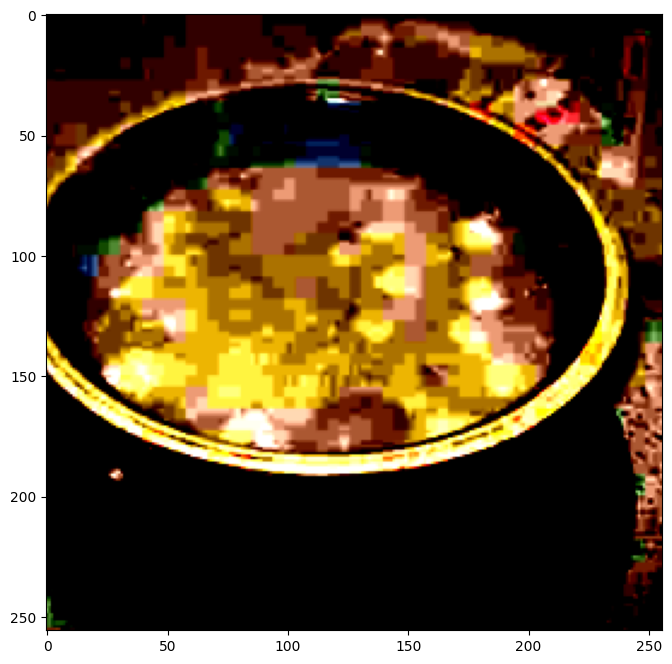

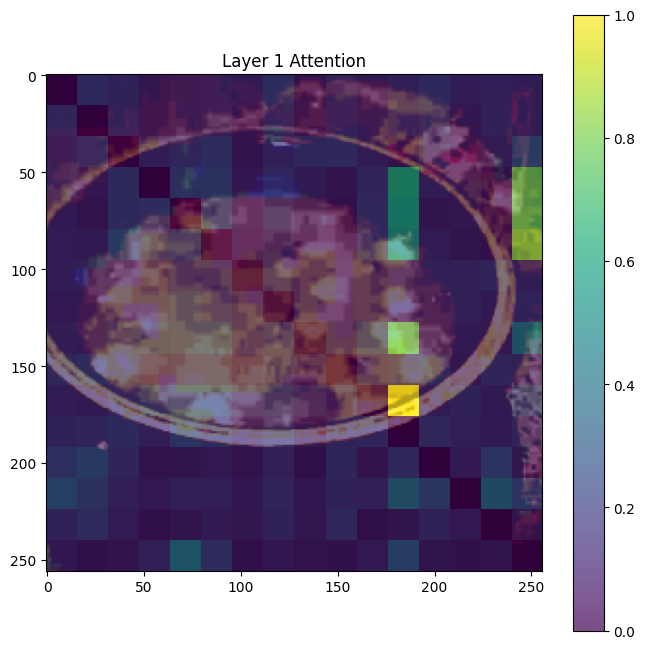

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Resized Attention Shape: (256, 256)


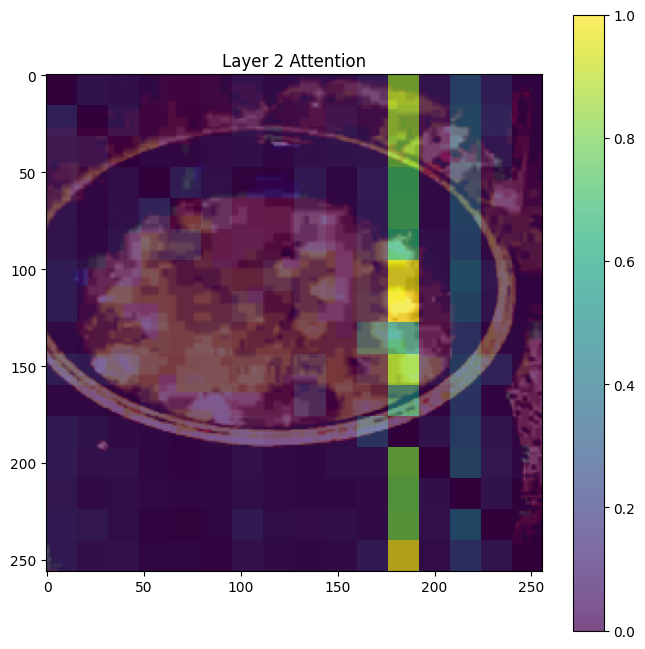

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Resized Attention Shape: (256, 256)


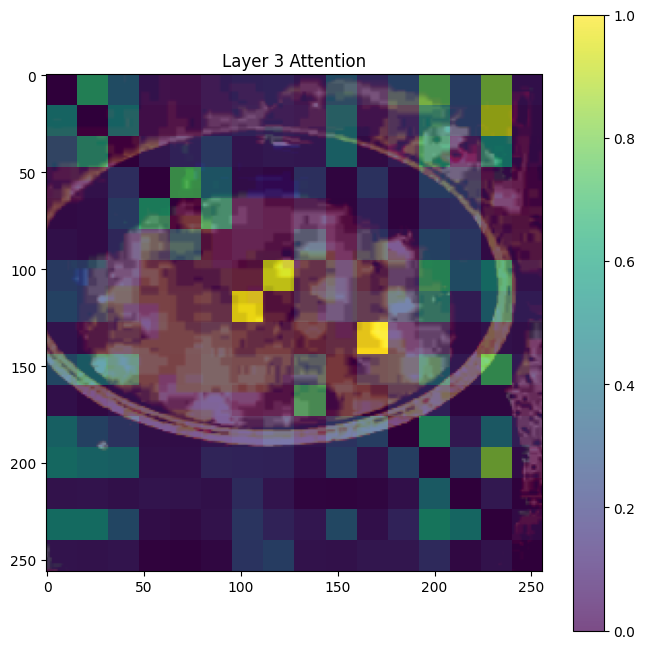

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Resized Attention Shape: (256, 256)


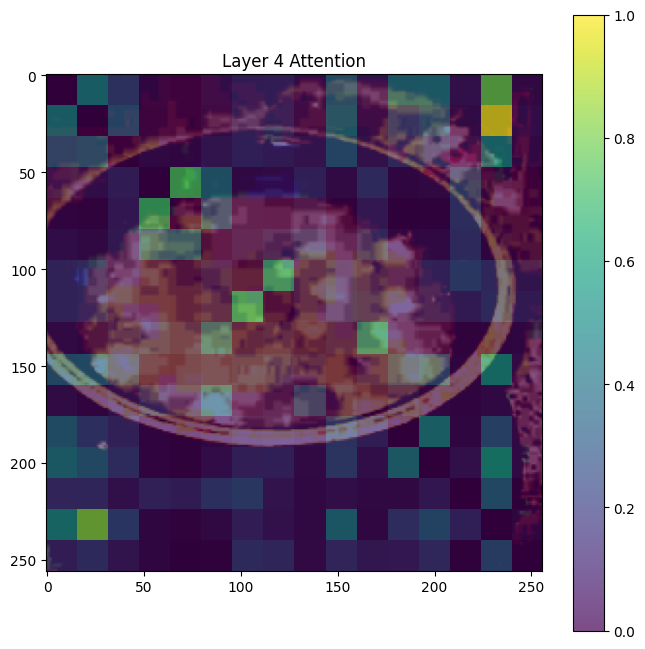

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Resized Attention Shape: (256, 256)


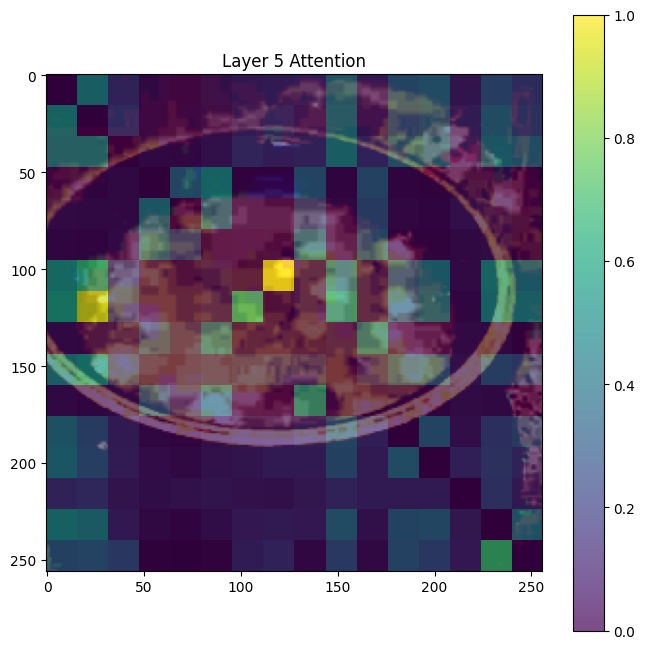

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Resized Attention Shape: (256, 256)


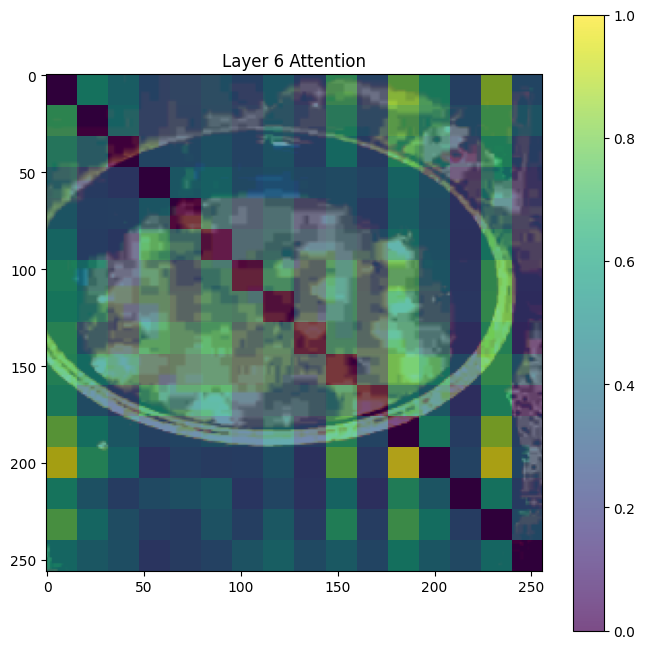

In [23]:
image_path = 'assets/Test/DSX/1675ILSVRC2013_train_00027470.JPEG_I1_Q7.jpeg'

image = Image.open(image_path)

image = transform(image)

with torch.no_grad():
    out, att = model(image.unsqueeze(0))
    _, preds = torch.max(out, 1)
    print(f"Predicted Class: {preds.cpu().numpy()[0]}")
    probabilities = nn.functional.softmax(out, dim=1)
    print(f"Probabilities: {probabilities.cpu().numpy()[0]}")
    print(f"Attention - Shape: {att.shape}") # batch, layers (depth), heads, sequence length, sequence length
    attn_patches = att[:, :, :,1:, 1:] # No Class-Token
    attn_patches = attn_patches.squeeze(0) # No Batch
    att_mean = torch.mean(attn_patches, dim=1) # Mean of Heads
    att_mean_scores = att_mean.cpu().numpy()

    print(f"Attention - Mean: {att_mean.shape}") # layers (depth), sequence length, sequence length
    # Overlay attention maps on the image patches
    image = image.permute(1,2,0)
    print(f"Image: {image.shape}")
    # Plot the original image with overlaid attention maps
    plt.figure(figsize=(8, 8))
    plt.imshow(image)  # Display the original image
    # Resize and normalize attention maps
    resized_and_normalized_attention_maps = resize_and_normalize_attention_maps(
        att_mean_scores, patch_size, image_size
    )
    # Overlay attention maps on the image patches
    for i, attention_map in enumerate(resized_and_normalized_attention_maps):
        print(f"Resized Attention Shape: {attention_map.shape}")
        # Plot the original image with overlaid attention maps
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.imshow(attention_map, alpha=0.7, cmap='viridis', interpolation='nearest')
        plt.title(f'Layer {i+1} Attention')
        plt.colorbar()
        plt.show()
